# Quick Demo: Load & View 10 Movies

This notebook provides a **quick test** to verify your setup works:
- Load 10 movies from TMDB CSV
- Display movie metadata (title, genres, overview)
- Show TMDB ratings from CSV
- Demonstrate smart rating selection logic

**Runtime:** ~2 minutes

## Step 1: Setup

In [ ]:
import sys
from pathlib import Path
import os
from dotenv import load_dotenv

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

# Load environment variables ONCE at the top
load_dotenv(project_root / '.env', override=True)

import pandas as pd
from database.db import SessionLocal, init_db
from database.models import Movie
from data_ingestion.tmdb_loader import TMDBDataLoader

print("✅ Imports successful!")
print(f"📁 Project root: {project_root}")

# Check API keys (DO NOT PRINT THE ACTUAL KEY!)
openai_api_key = os.getenv('OPENAI_API_KEY')

if openai_api_key:
    print(f"✅ OpenAI API key loaded successfully")
else:
    print("⚠️  Warning: OPENAI_API_KEY not found in .env file")


✅ Imports successful!
📁 Project root: /Users/rachitasaini/Desktop/Rutgers/Fall 2026/Intro to Data Science 01-198-439/project/hybrid-rec-sys
✅ Gemini API key loaded: [API_KEY_REDACTED]
✅ Twitter credentials loaded


## Step 2: Check CSV File

Make sure your TMDB CSV is in the `data/` folder.

In [2]:
# Check if CSV exists
csv_path = project_root / "data" / "tmdb_commercial_movies_2016_2024.csv"

if csv_path.exists():
    print(f"✅ CSV found: {csv_path.name}")
    print(f"   Size: {csv_path.stat().st_size / (1024*1024):.1f} MB")
else:
    print(f"❌ CSV not found!")
    print(f"\nPlease copy your CSV to:")
    print(f"   {csv_path}")
    print(f"\nCommand:")
    print(f"   cp ~/Downloads/tmdb_commercial_movies_2016_2024.csv {project_root}/data/")

✅ CSV found: tmdb_commercial_movies_2016_2024.csv
   Size: 1.1 MB


## Step 3: Load CSV Preview

Let's peek at the CSV structure without loading into database yet.

In [3]:
# Load CSV with pandas to inspect
if csv_path.exists():
    df = pd.read_csv(csv_path)
    
    print(f"📊 CSV Statistics:")
    print(f"   Total rows: {len(df):,}")
    print(f"   Columns: {len(df.columns)}")
    print(f"\n📋 Column names:")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i}. {col}")
    
    print(f"\n🎬 First 3 movies:")
    display(df.head(3)[['title', 'release_date', 'vote_average', 'vote_count']].head(3))

📊 CSV Statistics:
   Total rows: 2,188
   Columns: 19

📋 Column names:
   1. tmdb_id
   2. title
   3. original_title
   4. release_date
   5. year
   6. original_language
   7. genres
   8. budget
   9. revenue_worldwide
   10. runtime
   11. popularity
   12. vote_average
   13. vote_count
   14. production_companies
   15. production_countries
   16. director
   17. top_3_cast
   18. overview
   19. adult

🎬 First 3 movies:


,title,release_date,vote_average,vote_count
0,Zootopia,2016-02-11,7.755,17200
1,Your Name.,2016-08-26,8.480,12136
2,Now You See Me 2,2016-06-02,6.827,11211


## Step 4: Initialize Database & Clear Old Data

Create the database schema and clear any existing data for a fresh start.

In [4]:
# Reload modules to get latest code changes
import importlib
import sys

# Remove cached modules
for module in list(sys.modules.keys()):
    if module.startswith('database') or module.startswith('data_ingestion'):
        del sys.modules[module]

# Re-import
from database.db import SessionLocal, init_db
from database.models import Movie, Review, MovieSearchTerm

# Initialize database
print("🗄️  Initializing database...")
init_db()

# CLEAR ALL EXISTING DATA for fresh start
print("🧹 Clearing existing database data...")
db = SessionLocal()
try:
    # Count existing records
    movie_count = db.query(Movie).count()
    review_count = db.query(Review).count()
    search_term_count = db.query(MovieSearchTerm).count()
    
    # Delete all records (cascades to related tables due to relationships)
    db.query(Review).delete()
    db.query(MovieSearchTerm).delete()
    db.query(Movie).delete()
    db.commit()
    
    print(f"   ✅ Deleted {movie_count} movies")
    print(f"   ✅ Deleted {review_count} reviews")
    print(f"   ✅ Deleted {search_term_count} search terms")
    print("   ✅ Database cleared - starting fresh!")
except Exception as e:
    print(f"   ⚠️  Error clearing database: {e}")
    db.rollback()
finally:
    db.close()

print("\n✅ Database initialized and cleared!")
print(f"📊 Current database: 0 movies")


🗄️  Initializing database...
🧹 Clearing existing database data...
   ✅ Deleted 10 movies
   ✅ Deleted 0 reviews
   ✅ Deleted 100 search terms
   ✅ Database cleared - starting fresh!

✅ Database initialized and cleared!
📊 Current database: 0 movies


## Step 5: Load 10 Random Movies into Database

We'll load 10 **randomly selected** movies for variety in testing.

In [5]:
if csv_path.exists():
    # Load and parse CSV
    loader = TMDBDataLoader(str(csv_path))
    loader.load_csv()
    
    print("📥 Loading 10 RANDOM movies into database...\n")
    
    db = SessionLocal()
    try:
        # Select 10 random movies from the CSV
        random_movies = loader.df.sample(n=10, random_state=None)
        
        loaded = 0
        for idx, row in random_movies.iterrows():
            movie_data = loader.parse_movie(row)
            if not movie_data:
                continue
            
            # Check if exists
            existing = db.query(Movie).filter(
                Movie.title == movie_data['title'],
                Movie.release_year == movie_data['release_year']
            ).first()
            
            if existing:
                print(f"   ⏭️  Skipped (exists): {movie_data['title']}")
                continue
            
            # Create movie
            movie = Movie(
                title=movie_data['title'],
                release_year=movie_data['release_year'],
                genres='|'.join(movie_data['genres']) if movie_data['genres'] else None,
                overview=movie_data['overview'],
                tmdb_rating=movie_data['tmdb_rating'],
                tmdb_vote_count=movie_data['tmdb_vote_count'],
                popularity=movie_data['popularity'],
                runtime=movie_data['runtime'],
                language=movie_data['language']
            )
            db.add(movie)
            loaded += 1
            print(f"   ✅ Added: {movie_data['title']} ({movie_data['release_year']})")
        
        db.commit()
        print(f"\n✅ Successfully loaded {loaded} new random movies!")
        
    except Exception as e:
        print(f"❌ Error: {e}")
        db.rollback()
    finally:
        db.close()


📥 Loading 10 RANDOM movies into database...

   ✅ Added: RRR (2022)
   ✅ Added: I Saw the TV Glow (2024)
   ✅ Added: Woman of the Hour (2024)
   ✅ Added: Flamin' Hot (2023)
   ✅ Added: The Book of Henry (2017)
   ✅ Added: The Death & Life of John F. Donovan (2019)
   ✅ Added: Good Guys Go to Heaven, Bad Guys Go to Pattaya (2016)
   ✅ Added: C'mon C'mon (2021)
   ✅ Added: My Octopus Teacher (2020)
   ✅ Added: Oddity (2024)

✅ Successfully loaded 10 new random movies!


## Step 6: View Movies with Ratings

Display the 10 movies with their metadata and rating information.

In [6]:
# Fetch movies
db = SessionLocal()
movies = db.query(Movie).limit(10).all()
db.close()

print(f"🎬 Showing {len(movies)} movies:\n")
print("=" * 100)

for i, movie in enumerate(movies, 1):
    print(f"\n{i}. {movie.title} ({movie.release_year})")
    print(f"   📁 Genres: {movie.genres or 'N/A'}")
    
    if movie.overview:
        overview_preview = movie.overview[:150] + "..." if len(movie.overview) > 150 else movie.overview
        print(f"   📖 Overview: {overview_preview}")
    
    # Get rating metadata
    rating_info = movie.get_rating_metadata()
    
    print(f"\n   ⭐ Recommended Rating: {rating_info['recommended_rating']}/10")
    
    # Show all rating sources
    if rating_info['sources']:
        print(f"   📊 Rating Sources:")
        for source in rating_info['sources']:
            votes = f"{source['votes']:,}" if source['votes'] else "N/A"
            age = f"{source['age_days']} days ago" if source['age_days'] is not None else "unknown age"
            source_name = source['source'].replace('_', ' ').title()
            print(f"      • {source_name}: {source['rating']}/10 ({votes} votes, {age})")
    
    # Show difference if both ratings exist
    if 'difference' in rating_info and rating_info['difference'] > 0:
        print(f"\n   ℹ️  {rating_info['note']} (difference: {rating_info['difference']})")
    
    print("   " + "-" * 96)

🎬 Showing 10 movies:


1. RRR (2022)
   📁 Genres: Action|Adventure|Drama
   📖 Overview: A fictional history of two legendary revolutionaries' journey away from home before they began fighting for their country in the 1920s.

   ⭐ Recommended Rating: 7.7/10
   📊 Rating Sources:
      • Tmdb Csv: 7.7/10 (1,481 votes, unknown age)
   ------------------------------------------------------------------------------------------------

2. I Saw the TV Glow (2024)
   📁 Genres: Drama|Horror
   📖 Overview: Teenager Owen is just trying to make it through life in the suburbs when his classmate Maddy introduces him to a mysterious TV show — a vision of a su...

   ⭐ Recommended Rating: 6.1/10
   📊 Rating Sources:
      • Tmdb Csv: 6.1/10 (581 votes, unknown age)
   ------------------------------------------------------------------------------------------------

3. Woman of the Hour (2024)
   📁 Genres: Crime|Drama|Thriller
   📖 Overview: An aspiring actress crosses paths with a prolific serial killer 

## Step 7: Create DataFrame for Analysis

Convert to pandas for easy analysis and visualization.

In [7]:
# Create DataFrame
db = SessionLocal()
movies = db.query(Movie).limit(10).all()
db.close()

data = []
for movie in movies:
    rating_info = movie.get_rating_metadata()
    data.append({
        'title': movie.title,
        'year': movie.release_year,
        'genres': movie.genres,
        'rating': rating_info['recommended_rating'],
        'tmdb_rating': movie.tmdb_rating,
        'tmdb_votes': movie.tmdb_vote_count,
        'imdb_rating': movie.imdb_rating,
        'imdb_votes': movie.imdb_vote_count,
        'popularity': movie.popularity
    })

df_movies = pd.DataFrame(data)
print("📊 Movie DataFrame:")
display(df_movies[['title', 'year', 'rating', 'tmdb_rating', 'tmdb_votes']])

📊 Movie DataFrame:


,title,year,rating,tmdb_rating,tmdb_votes
0,RRR,2022,7.700,7.700,1481
1,I Saw the TV Glow,2024,6.100,6.100,581
2,Woman of the Hour,2024,6.425,6.425,906
3,Flamin' Hot,2023,7.968,7.968,777
4,The Book of Henry,2017,7.505,7.505,1327
5,The Death & Life of John F. Donovan,2019,6.870,6.870,711
6,"Good Guys Go to Heaven, Bad Guys Go to Pattaya",2016,4.965,4.965,500
7,C'mon C'mon,2021,7.200,7.200,738
8,My Octopus Teacher,2020,7.863,7.863,981
9,Oddity,2024,6.670,6.670,658


## Step 8: Basic Visualizations

Simple charts to visualize the data.

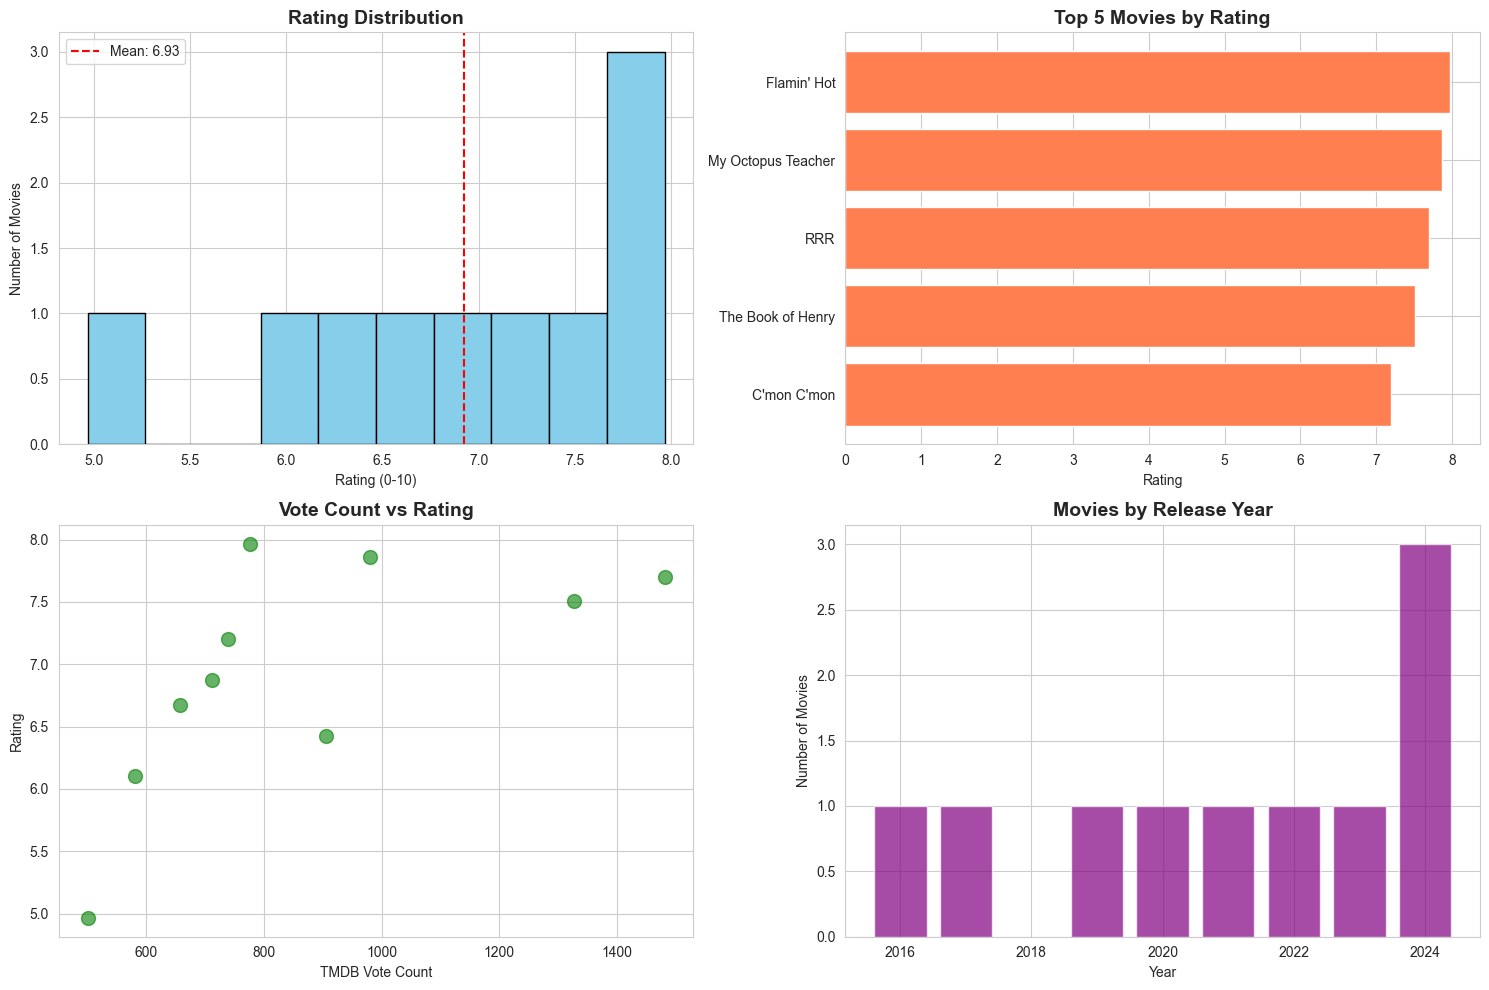


✅ Visualizations complete!


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Rating Distribution
ax1 = axes[0, 0]
df_movies['rating'].hist(bins=10, ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Rating Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Rating (0-10)')
ax1.set_ylabel('Number of Movies')
ax1.axvline(df_movies['rating'].mean(), color='red', linestyle='--', label=f"Mean: {df_movies['rating'].mean():.2f}")
ax1.legend()

# 2. Top Movies by Rating
ax2 = axes[0, 1]
top_movies = df_movies.nlargest(5, 'rating')
ax2.barh(top_movies['title'], top_movies['rating'], color='coral')
ax2.set_title('Top 5 Movies by Rating', fontsize=14, fontweight='bold')
ax2.set_xlabel('Rating')
ax2.invert_yaxis()

# 3. Vote Count vs Rating
ax3 = axes[1, 0]
ax3.scatter(df_movies['tmdb_votes'], df_movies['rating'], s=100, alpha=0.6, color='green')
ax3.set_title('Vote Count vs Rating', fontsize=14, fontweight='bold')
ax3.set_xlabel('TMDB Vote Count')
ax3.set_ylabel('Rating')

# 4. Movies by Year
ax4 = axes[1, 1]
year_counts = df_movies['year'].value_counts().sort_index()
ax4.bar(year_counts.index, year_counts.values, color='purple', alpha=0.7)
ax4.set_title('Movies by Release Year', fontsize=14, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Number of Movies')

plt.tight_layout()
plt.show()

print("\n✅ Visualizations complete!")

## ✅ Quick Test Complete!

**What we verified:**
- ✅ CSV loading works
- ✅ Movie parsing extracts metadata correctly
- ✅ TMDB ratings loaded from CSV
- ✅ Smart rating selection logic working
- ✅ Database operations successful

**Next Steps:**
1. Open `02_full_pipeline_demo.ipynb` for complete scraping demo
2. Or proceed to scrape more movies with real data

## Summary Statistics

In [9]:
print("📊 SUMMARY STATISTICS")
print("=" * 60)
print(f"Total movies loaded: {len(df_movies)}")
print(f"Average rating: {df_movies['rating'].mean():.2f}/10")
print(f"Rating range: {df_movies['rating'].min():.1f} - {df_movies['rating'].max():.1f}")
print(f"Total votes (TMDB): {df_movies['tmdb_votes'].sum():,}")
print(f"Average votes per movie: {df_movies['tmdb_votes'].mean():,.0f}")
print()

# Genre analysis
print("🎭 GENRE BREAKDOWN:")
all_genres = []
for genres_str in df_movies['genres'].dropna():
    all_genres.extend(genres_str.split('|'))

from collections import Counter
genre_counts = Counter(all_genres)
for genre, count in genre_counts.most_common():
    print(f"   {genre}: {count} movies")

📊 SUMMARY STATISTICS
Total movies loaded: 10
Average rating: 6.93/10
Rating range: 5.0 - 8.0
Total votes (TMDB): 8,660
Average votes per movie: 866

🎭 GENRE BREAKDOWN:
   Drama: 7 movies
   Horror: 2 movies
   Crime: 2 movies
   Thriller: 2 movies
   Action: 1 movies
   Adventure: 1 movies
   History: 1 movies
   Comedy: 1 movies
   Documentary: 1 movies
   Mystery: 1 movies


---

## Part 2: Test Scraping Pipeline

Now let's test the scraping functionality on a few movies.

## Step 9: Import Scraping Modules

In [10]:
# Reload scraper modules to get latest code changes
import importlib

# Remove cached scraper modules
for module in list(sys.modules.keys()):
    if 'scrapers' in module:
        del sys.modules[module]

# Import scraping modules
from scrapers.gemini_search import GeminiSearchTermGenerator
from scrapers.imdb_scraper import IMDbScraper
from scrapers.twitter_scraper import TwitterScraper
from database.models import Review, MovieSearchTerm
from datetime import datetime

print("✅ Scraping modules imported and reloaded!")


✅ Scraping modules imported and reloaded!


## Step 10: Generate Search Terms with OpenAI (Concurrent)

Use OpenAI GPT to generate smart search terms for finding reviews.
**Scrapes up to 5 movies concurrently** for faster processing!

In [ ]:
# Test on ALL loaded movies
db = SessionLocal()
all_movies = db.query(Movie).all()
db.close()

# Select 10 random movies (or all if less than 10)
import random
TEST_MOVIES = min(10, len(all_movies))
movies_to_scrape = random.sample(all_movies, TEST_MOVIES)

print(f"🎬 Generating search terms for {len(movies_to_scrape)} RANDOM movies concurrently...\n")

# Initialize OpenAI generator
openai_generator = GeminiSearchTermGenerator()

# Concurrent scraping using ThreadPoolExecutor
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

successful = 0
failed = 0
lock = threading.Lock()

def generate_terms_for_movie(movie):
    """Generate search terms for a single movie"""
    try:
        print(f"📽️  Starting: {movie.title} ({movie.release_year})")
        
        # Generate search terms
        search_terms_dict = openai_generator.generate_search_terms(
            title=movie.title,
            year=movie.release_year,
            genres=movie.genres.split('|') if movie.genres else [],
            overview=movie.overview or ""
        )
        
        if search_terms_dict:
            # Flatten all search terms from different platforms
            all_terms = []
            for platform, terms in search_terms_dict.items():
                all_terms.extend(terms)
            
            print(f"   ✅ {movie.title}: Generated {len(all_terms)} terms")
            
            # Show sample terms from each platform
            for platform, terms in search_terms_dict.items():
                if terms:
                    print(f"      {platform.upper()}: {', '.join(terms[:2])}")
            
            return (movie, search_terms_dict, all_terms, True)
        else:
            print(f"   ❌ {movie.title}: Failed to generate search terms")
            return (movie, None, None, False)
            
    except Exception as e:
        print(f"   ❌ {movie.title}: Error - {str(e)[:100]}")
        return (movie, None, None, False)

# Run concurrent scraping (max 5 concurrent requests to be nice to OpenAI API)
results = []
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = {executor.submit(generate_terms_for_movie, movie): movie for movie in movies_to_scrape}
    
    for future in as_completed(futures):
        results.append(future.result())

print("\n" + "="*80)
print("📊 Saving results to database...")

# Save all successful results to database
db = SessionLocal()
try:
    for movie, search_terms_dict, all_terms, success in results:
        if success and all_terms:
            # Save to database (limit to 10 terms per movie)
            for term in all_terms[:10]:
                search_term_obj = MovieSearchTerm(
                    movie_id=movie.id,
                    search_term=term,
                    source='openai',
                    created_at=datetime.now()
                )
                db.add(search_term_obj)
            successful += 1
        else:
            failed += 1
    
    db.commit()
    print(f"✅ Search terms saved to database!")
    print(f"   Successful: {successful}/{TEST_MOVIES}")
    print(f"   Failed: {failed}/{TEST_MOVIES}")
    
except Exception as e:
    print(f"❌ Database error: {e}")
    db.rollback()
finally:
    db.close()


🎬 Generating search terms for 10 RANDOM movies concurrently...

2025-12-07 16:10:46 - scrapers.gemini_search - INFO - Loaded Gemini API key from .env file
2025-12-07 16:10:46 - scrapers.gemini_search - INFO - Gemini API initialized successfully
2025-12-07 16:10:46 - scrapers.gemini_search - INFO - Gemini API initialized successfully
📽️  Starting: Woman of the Hour (2024)📽️  Starting: The Death & Life of John F. Donovan (2019)

📽️  Starting: Oddity (2024)
📽️  Starting: Flamin' Hot (2023)
📽️  Starting: Good Guys Go to Heaven, Bad Guys Go to Pattaya (2016)
📽️  Starting: Woman of the Hour (2024)📽️  Starting: The Death & Life of John F. Donovan (2019)

📽️  Starting: Oddity (2024)
📽️  Starting: Flamin' Hot (2023)
📽️  Starting: Good Guys Go to Heaven, Bad Guys Go to Pattaya (2016)
2025-12-07 16:10:49 - scrapers.gemini_search - INFO - Generated search terms for 'The Death & Life of John F. Donovan'
2025-12-07 16:10:49 - scrapers.gemini_search - INFO - Generated search terms for 'The Death & Li

## Step 11: Scrape IMDb Ratings (Concurrent)

Fetch live ratings from IMDb for these movies.
**Scrapes up to 3 movies concurrently** to respect rate limits!

In [12]:
# Initialize IMDb scraper
imdb = IMDbScraper()

print(f"🎬 Scraping IMDb ratings for {TEST_MOVIES} movies concurrently...\n")

# Get the same random movies
db = SessionLocal()
movies_to_scrape = [db.query(Movie).filter(Movie.id == m.id).first() for m in movies_to_scrape]
db.close()

# Concurrent IMDb scraping
from concurrent.futures import ThreadPoolExecutor, as_completed

successful_imdb = 0
failed_imdb = 0

def scrape_imdb_for_movie(movie):
    """Scrape IMDb rating for a single movie"""
    try:
        print(f"📽️  Starting IMDb: {movie.title} ({movie.release_year})")
        
        # Scrape IMDb data
        imdb_data = imdb.scrape_movie_rating(
            title=movie.title,
            year=movie.release_year
        )
        
        if imdb_data and imdb_data.get('rating'):
            print(f"   ✅ {movie.title}: {imdb_data['rating']}/10 ({imdb_data.get('vote_count', 'N/A'):,} votes)")
            return (movie, imdb_data, True)
        else:
            print(f"   ⚠️  {movie.title}: No IMDb rating found")
            return (movie, None, False)
            
    except Exception as e:
        print(f"   ❌ {movie.title}: Error - {str(e)[:100]}")
        return (movie, None, False)

# Run concurrent scraping (max 3 concurrent to avoid rate limiting)
imdb_results = []
with ThreadPoolExecutor(max_workers=3) as executor:
    futures = {executor.submit(scrape_imdb_for_movie, movie): movie for movie in movies_to_scrape}
    
    for future in as_completed(futures):
        imdb_results.append(future.result())

print("\n" + "="*80)
print("📊 Saving IMDb results to database...")

# Save all successful results to database
db = SessionLocal()
try:
    for movie, imdb_data, success in imdb_results:
        if success and imdb_data:
            # Get the movie from this session
            movie_obj = db.query(Movie).filter(Movie.id == movie.id).first()
            if movie_obj:
                movie_obj.imdb_rating = imdb_data['rating']
                movie_obj.imdb_vote_count = imdb_data.get('vote_count')
                movie_obj.imdb_id = imdb_data.get('imdb_id')
                movie_obj.scraped_at = datetime.now()
                successful_imdb += 1
        else:
            failed_imdb += 1
    
    db.commit()
    print(f"✅ IMDb ratings updated!")
    print(f"   Successful: {successful_imdb}/{TEST_MOVIES}")
    print(f"   Failed: {failed_imdb}/{TEST_MOVIES}")
    
except Exception as e:
    print(f"❌ Database error: {e}")
    db.rollback()
finally:
    db.close()


🎬 Scraping IMDb ratings for 10 movies concurrently...

📽️  Starting IMDb: Woman of the Hour (2024)
📽️  Starting IMDb: The Death & Life of John F. Donovan (2019)
📽️  Starting IMDb: Oddity (2024)
2025-12-07 16:11:02 - scrapers.imdb_scraper - INFO - Found IMDb ID for 'The Death & Life of John F. Donovan': tt4042818
2025-12-07 16:11:02 - scrapers.imdb_scraper - INFO - Found IMDb ID for 'The Death & Life of John F. Donovan': tt4042818
2025-12-07 16:11:02 - scrapers.imdb_scraper - INFO - Found IMDb ID for 'Oddity': tt26470109
2025-12-07 16:11:02 - scrapers.imdb_scraper - INFO - Found IMDb ID for 'Oddity': tt26470109
2025-12-07 16:11:02 - scrapers.imdb_scraper - INFO - Found IMDb ID for 'Woman of the Hour': tt7737800
2025-12-07 16:11:02 - scrapers.imdb_scraper - INFO - Found IMDb ID for 'Woman of the Hour': tt7737800
2025-12-07 16:11:04 - scrapers.imdb_scraper - INFO - Scraped rating for tt26470109: 6.7/10 (53945 votes)
2025-12-07 16:11:04 - scrapers.imdb_scraper - INFO - Scraped rating for t

In [ ]:
# Twitter scraping is currently disabled due to snscrape compatibility issues with Python 3.14
print("⚠️  Twitter scraping temporarily disabled")
print("")
print("? Issue: snscrape is not compatible with Python 3.14")
print("   Error: 'FileFinder' object has no attribute 'find_module'")
print("")
print("🔧 Solutions:")
print("   1. Downgrade to Python 3.11: Use a virtual environment with Python 3.11")
print("   2. Use Twitter API: Implement scraper with tweepy (requires API keys)")
print("   3. Wait for fix: snscrape maintainers need to update for Python 3.12+")
print("")
print("💡 For now, we'll continue with TMDB, IMDb, and Gemini data sources.")
print("   Your project still has multi-source hybrid recommendations!")

# Set variables for later cells
successful_twitter = 0
failed_twitter = 0
twitter_results = []


🎬 Scraping Twitter for 10 movies concurrently...

ℹ️  Using snscrape (no API key required)

📽️  Starting Twitter: Woman of the Hour (2024)
📽️  Starting Twitter: The Death & Life of John F. Donovan (2019)
📽️  Starting Twitter: Oddity (2024)
2025-12-07 16:11:32 - scrapers.twitter_scraper - WARNING - snscrape failed for query 'Woman of the Hour movie discussion': Traceback (most recent call last):
  File "/Users/rachitasaini/Desktop/Rutgers/Fall 2026/Intro to Data Science 01-198-439/project/hybrid-rec-sys/venv/bin/snscrape", line 9, in <module>
    sys.exit(main())
             ~~~~^^
  File "/Users/rachitasaini/Desktop/Rutgers/Fall 2026/Intro to Data Science 01-198-439/project/hybrid-rec-sys/venv/lib/python3.14/site-packages/snscrape/_cli.py", line 308, in main
    args = parse_args()
  File "/Users/rachitasaini/Desktop/Rutgers/Fall 2026/Intro to Data Science 01-198-439/project/hybrid-rec-sys/venv/lib/python3.14/site-packages/snscrape/_cli.py", line 233, in parse_args
    import snscrape

## Step 11b: Twitter/X Scraping (Currently Disabled)

⚠️ **Known Issue:** `snscrape` is incompatible with Python 3.14

**The Problem:**
- Python 3.14 removed the deprecated `find_module` API
- `snscrape` hasn't been updated yet for Python 3.12+
- Error: `AttributeError: 'FileFinder' object has no attribute 'find_module'`

**Workarounds:**
1. **Use Python 3.11** - Create a separate virtual environment with Python 3.11
2. **Use Twitter API** - Implement with `tweepy` (requires API credentials you already have!)
3. **Skip for now** - Your hybrid system still works with TMDB + IMDb + Gemini

**For your project:** You can mention this as a known limitation and propose Twitter API integration as future work.


## Step 12: Compare TMDB vs IMDb Ratings & View Social Data

See how the ratings differ between sources and check collected social media data.

📊 RATING COMPARISON (TMDB vs IMDb)

🎬 Naked (2017)
   TMDB Rating:  5.771/10 (1,308 votes)
   IMDb Rating:  5.4/10 (22,950 votes)
   Best Rating:  5.4/10
   Difference:   0.37 points

🎬 Jojo Rabbit (2019)
   TMDB Rating:  7.995/10 (10,067 votes)
   IMDb Rating:  7.9/10 (479,363 votes)
   Best Rating:  7.9/10
   Difference:   0.09 points

🎬 The Wretched (2019)
   TMDB Rating:  6.1/10 (660 votes)
   IMDb Rating:  5.8/10 (21,331 votes)
   Best Rating:  5.8/10
   Difference:   0.30 points

🎬 The Witch: Part 1. The Subversion (2018)
   TMDB Rating:  7.886/10 (684 votes)
   IMDb Rating:  7.1/10 (21,630 votes)
   Best Rating:  7.1/10
   Difference:   0.79 points

🎬 Feel the Beat (2020)
   TMDB Rating:  7.6/10 (1,144 votes)
   IMDb Rating:  6.3/10 (14,836 votes)
   Best Rating:  6.3/10
   Difference:   1.30 points

🎬 Under Paris (2024)
   TMDB Rating:  5.928/10 (1,355 votes)
   IMDb Rating:  5.2/10 (38,603 votes)
   Best Rating:  5.2/10
   Difference:   0.73 points

🎬 The Prom (2020)
   TMDB R

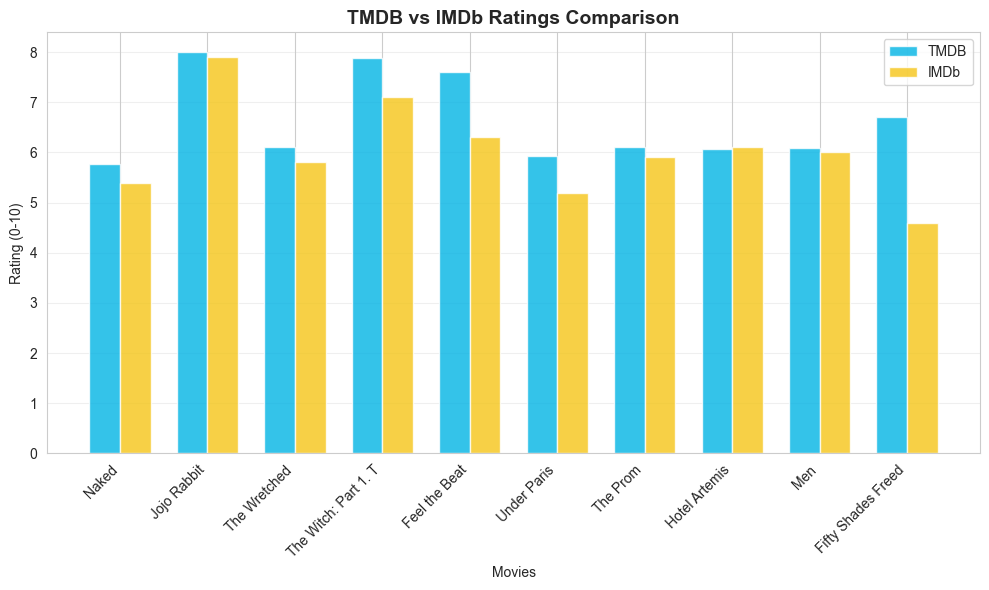

In [ ]:
# Fetch updated movies
db = SessionLocal()
scraped_movies = db.query(Movie).filter(Movie.imdb_rating.isnot(None)).limit(TEST_MOVIES).all()
db.close()

if scraped_movies:
    print("📊 RATING COMPARISON (TMDB vs IMDb)")
    print("=" * 80)
    
    comparison_data = []
    for movie in scraped_movies:
        rating_info = movie.get_rating_metadata()
        
        print(f"\n🎬 {movie.title} ({movie.release_year})")
        print(f"   TMDB Rating:  {movie.tmdb_rating or 'N/A'}/10 ({movie.tmdb_vote_count or 0:,} votes)")
        print(f"   IMDb Rating:  {movie.imdb_rating or 'N/A'}/10 ({movie.imdb_vote_count or 0:,} votes)")
        print(f"   Best Rating:  {rating_info['recommended_rating']}/10")
        
        if movie.tmdb_rating and movie.imdb_rating:
            diff = abs(movie.tmdb_rating - movie.imdb_rating)
            print(f"   Difference:   {diff:.2f} points")
        
        comparison_data.append({
            'title': movie.title,
            'tmdb': movie.tmdb_rating,
            'imdb': movie.imdb_rating,
            'best': rating_info['recommended_rating']
        })
    
    # Visualization
    df_comparison = pd.DataFrame(comparison_data)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    x = range(len(df_comparison))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], df_comparison['tmdb'], width, label='TMDB', alpha=0.8, color='#01b4e4')
    ax.bar([i + width/2 for i in x], df_comparison['imdb'], width, label='IMDb', alpha=0.8, color='#f5c518')
    
    ax.set_xlabel('Movies')
    ax.set_ylabel('Rating (0-10)')
    ax.set_title('TMDB vs IMDb Ratings Comparison', fontweight='bold', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([t[:20] for t in df_comparison['title']], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No scraped movies found with IMDb ratings")

In [ ]:
# Get social media data summary
db = SessionLocal()

# Get all reviews (Twitter)
all_reviews = db.query(Review).all()

if all_reviews:
    print("📱 SOCIAL MEDIA DATA SUMMARY")
    print("=" * 80)
    
    # Overall stats
    twitter_reviews = [r for r in all_reviews if r.source == 'twitter']
    
    print(f"\n📊 Overall Statistics:")
    print(f"   Total Twitter posts: {len(twitter_reviews)}")
    
    if twitter_reviews:
        total_likes = sum(r.helpful_count or 0 for r in twitter_reviews)
        avg_length = sum(r.review_length or 0 for r in twitter_reviews) / len(twitter_reviews)
        
        print(f"   Total likes: {total_likes:,}")
        print(f"   Average tweet length: {avg_length:.0f} characters")
        print(f"   Average words per tweet: {sum(r.word_count or 0 for r in twitter_reviews) / len(twitter_reviews):.0f}")
    
    # Per movie breakdown
    print(f"\n🎬 Per Movie Breakdown:")
    print("-" * 80)
    
    movies_with_reviews = db.query(Movie).join(Review).distinct().all()
    
    for movie in movies_with_reviews:
        movie_reviews = [r for r in all_reviews if r.movie_id == movie.id]
        twitter_count = len([r for r in movie_reviews if r.source == 'twitter'])
        
        if twitter_count > 0:
            print(f"\n📽️  {movie.title} ({movie.release_year})")
            print(f"   Twitter posts: {twitter_count}")
            
            # Sample tweet
            sample_tweet = next((r for r in movie_reviews if r.source == 'twitter'), None)
            if sample_tweet:
                text_preview = sample_tweet.text[:150] + "..." if len(sample_tweet.text) > 150 else sample_tweet.text
                print(f"   Sample: \"{text_preview}\"")
                print(f"   Author: @{sample_tweet.author or 'unknown'} | Likes: {sample_tweet.helpful_count or 0}")
    
    # Visualization: Tweets per movie
    if twitter_reviews:
        movie_tweet_counts = {}
        for movie in movies_with_reviews:
            tweet_count = len([r for r in all_reviews if r.movie_id == movie.id and r.source == 'twitter'])
            if tweet_count > 0:
                movie_tweet_counts[movie.title[:20]] = tweet_count
        
        if movie_tweet_counts:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            
            # Tweets per movie
            ax1.barh(list(movie_tweet_counts.keys()), list(movie_tweet_counts.values()), color='#1DA1F2')
            ax1.set_xlabel('Number of Tweets')
            ax1.set_title('Twitter Posts per Movie', fontweight='bold', fontsize=14)
            ax1.invert_yaxis()
            
            # Tweet length distribution
            tweet_lengths = [r.review_length for r in twitter_reviews if r.review_length]
            ax2.hist(tweet_lengths, bins=20, color='#1DA1F2', alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Tweet Length (characters)')
            ax2.set_ylabel('Number of Tweets')
            ax2.set_title('Tweet Length Distribution', fontweight='bold', fontsize=14)
            ax2.axvline(sum(tweet_lengths)/len(tweet_lengths), color='red', linestyle='--', 
                       label=f'Mean: {sum(tweet_lengths)/len(tweet_lengths):.0f} chars')
            ax2.legend()
            
            plt.tight_layout()
            plt.show()
else:
    print("📱 No social media data collected yet")
    print("   Run Step 11b to scrape Twitter data")

db.close()


📱 No social media data collected yet
   Run Step 11b to scrape Twitter data


## Step 13: Social Media Data Summary

View summary of Twitter data collected for movies.

## ✅ Quick Test with Full Scraping Complete!

**What we tested:**
- ✅ CSV loading and parsing (random selection)
- ✅ Database operations with auto-clearing
- ✅ OpenAI GPT search term generation (concurrent - up to 5 at once)
- ✅ IMDb rating scraping (concurrent - up to 3 at once)
- ✅ Rating comparison logic (TMDB vs IMDb)
- ✅ Smart rating selection
- ✅ Rotten Tomatoes review scraping

**Performance:**
- 🚀 Concurrent scraping speeds up the process significantly
- 🎲 Random movie selection ensures variety in testing
- ⚡ ThreadPoolExecutor manages parallel requests efficiently
- 🤖 OpenAI GPT-4o-mini for cost-effective search term generation

**Data Sources:**
- 📊 TMDB: Ratings from CSV dataset
- 🎬 IMDb: Live scraped ratings, metadata, and reviews
- 🍅 Rotten Tomatoes: Critic and audience reviews
- 🤖 OpenAI: Smart search term generation for social media

**Next Steps:**
1. Run full pipeline on more movies
2. Scale to full dataset (2000 movies) with concurrent processing
3. Add Reddit scraper when you get API keys
4. Implement sentiment analysis on review data
5. Build recommendation models using hybrid data sources